In [59]:
%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import numpy as np

import scipy.signal as sps

from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode
from PIL import Image

In [42]:
infd = open('vezone.ld', 'rb')

bufsize = 1820 * 525 * 30
inbuf = infd.read(bufsize * 2)
data = np.fromstring(inbuf, 'uint16', len(inbuf)//2)

print(data.shape)

(14668725,)


In [105]:
# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 1820, y = 525, vscale = 1, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x, y * vscale)
    
    bmf = np.uint8(bm[0:1820*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
#    imshow(np.asarray(im))
    b = BytesIO()
    im.save(b, format='jpeg')
    return IPython.display.Image(b.getvalue())
                         
#drawdata(data)                         

(955500,)
uint8 (525, 1820) (525, 1820)


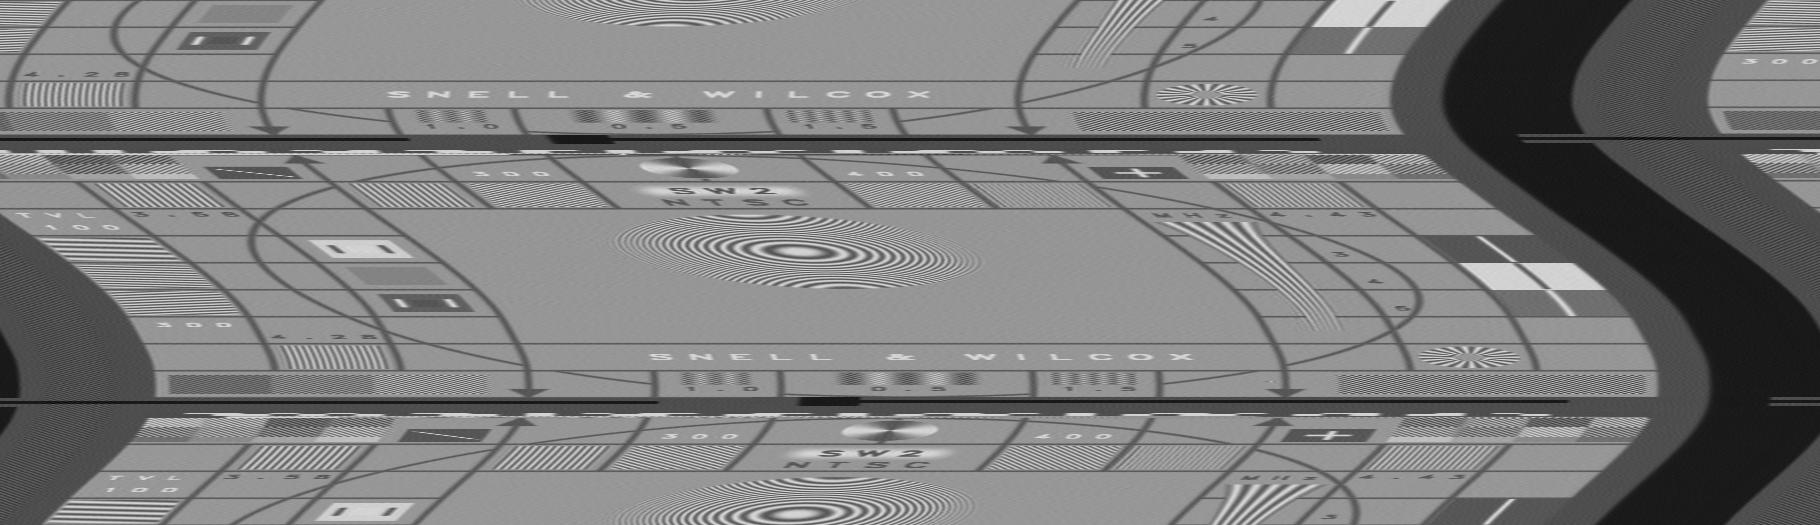

In [44]:
drawdata(data)

In [45]:
# This follows the default scale in lddecodercuda
minire = -60
maxire = 140

hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)

out_scale = 65534.0 / (maxire - minire)

def RawToIRE(data):
    return (np.float32(data) / out_scale) + minire

def IREToRaw(data):
    return np.uint16((data - minire) * out_scale)

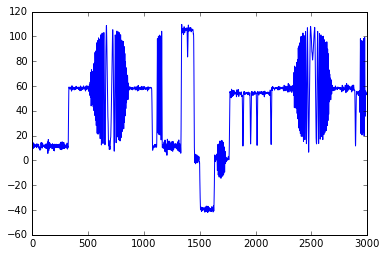

In [46]:
plt.plot(RawToIRE(data[0:3000]))

In [47]:
synctrig = IREToRaw(-21)
sdata = data < synctrig

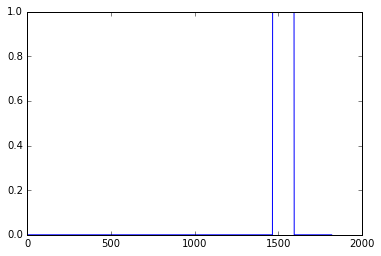

In [48]:
plt.plot(sdata[78260:78260+1820])

In [49]:
FSC = 8
freq_mhz = (315.0 / 88.0) * FSC
freq_hz = freq_mhz * 1000000.0

Ncolor = 24
sync_filter = sps.firwin(Ncolor + 1, 0.1 / (freq_mhz / 2.0), window='hamming')

def findpeaks(data):
    dinput = np.diff(data)
    dpeaks = (dinput[:-1] > 0) & (dinput[1:] < 0)
    
#    print(dinput)   
#    print(dpeaks)
    
    return np.where(dpeaks)[0]
    
f_syncid_b, f_syncid_a = sps.butter(3, 0.002)

def findsyncs(data):
    # Parameters
    synctrig = IREToRaw(-25) # this value should be below any probable colorburst
    hslen = range(FSC * 14, FSC * 17) # typical range of horizontal syncs at synctrig level
    scanlength = int(FSC * (227.5 * 1.25)) # long enough to cover an entire line, but not long enough to see the half-line hsync as well
    
    sdata = data < synctrig
    sfdata = sps.lfilter(f_syncid_b, f_syncid_a, sdata)
    
    #vsync = sfdata > 0.5
    #hsync = (sfdata > 0.2) & (vsync == False)
    
    peaks = findpeaks(sfdata)
    print (peaks)
    vsyncs = []
    cvsync = None
    
    # we need to detect the gaps before/after the last full vsync pulse to the prev/next regular hsync,
    # to see which kind of field we're dealing with
    previ = 0
    prevv = 0
    for i in peaks:
#        print(i, sfdata[i])
        if sfdata[i] > 0.5:
            if previ == None:
                return (1820 * 500), None, None
            
            if len(vsyncs) == 0 or cvsync['gap2'] is not None:
                cvsync = {'hsyncs': [], 'gap1': (i - previ), 'gap2': None}
                vsyncs.append(cvsync)
            
            prevv = i
        elif sfdata[i] > 0.25:
            if cvsync is not None:
                if cvsync['gap2'] is None:
                    cvsync['gap2'] = i - prevv
                    
                cvsync['hsyncs'].append(i)
                
            previ = i
    
    # return a few lines back before the last vsync, so the next read can start correctly
    return vsyncs[-2]['hsyncs'][-3], vsyncs, sfdata
#    return peaks, vsyncs, sfdata

from datetime import datetime
ts = datetime.now()
rlen, peaks, sfdata = findsyncs(data)
print(datetime.now() - ts)

[    1895     3108     3714 ..., 14666912 14667547 14668221]
0:00:00.490396


In [51]:
peaks[0]

{'gap1': 7668,
 'gap2': 5957,
 'hsyncs': [262122,
  263938,
  265759,
  267580,
  269401,
  271222,
  273043,
  274864,
  276686,
  278507,
  280328,
  282149,
  283970,
  285791,
  287612,
  289434,
  291255,
  293076,
  294898,
  296719,
  298540,
  300362,
  302183,
  304004,
  305826,
  307647,
  309468,
  311289,
  313111,
  314932,
  316754,
  318575,
  320396,
  322218,
  324039,
  325860,
  327682,
  329503,
  331325,
  333146,
  334967,
  336788,
  338610,
  340431,
  342253,
  344074,
  345895,
  347717,
  349538,
  351360,
  353181,
  355002,
  356823,
  358645,
  360466,
  362288,
  364109,
  365930,
  367752,
  369573,
  371395,
  373216,
  375037,
  376858,
  378680,
  380501,
  382323,
  384144,
  385966,
  387787,
  389608,
  391430,
  393251,
  395073,
  396894,
  398716,
  400537,
  402359,
  404180,
  406001,
  407823,
  409644,
  411466,
  413287,
  415108,
  416930,
  418752,
  420573,
  422395,
  424216,
  426038,
  427859,
  429680,
  431502,
  433323,
  435145,


In [36]:
6758.0/6862.0, 7665.0/5954.0

(0.984844068784611, 1.28736983540477)

31
(955500,)
uint8 (525, 1820) (525, 1820)


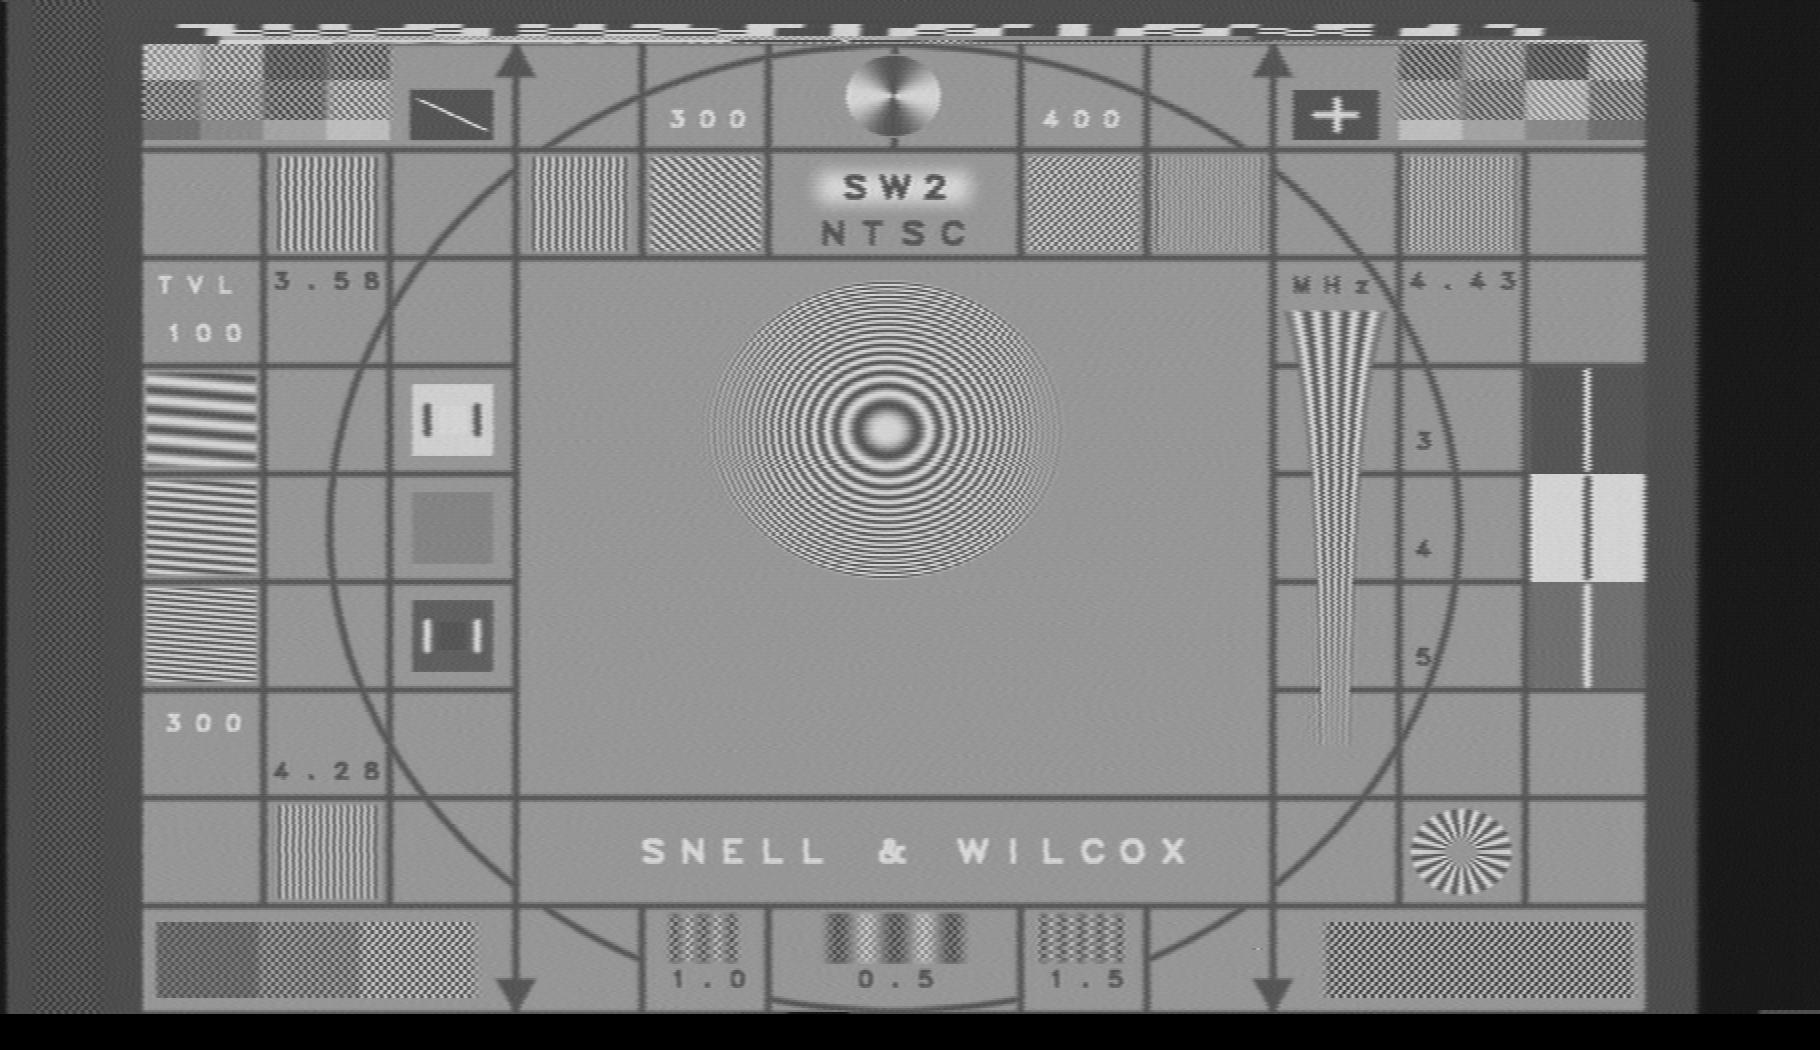

In [108]:
def frameup(data, peaks, sfdata):
    print(len(peaks))

    frame = np.zeros(1820 * 525, dtype=np.uint16)
    
    frameno = -1
    for i in range(0, len(peaks)):
        field = peaks[i]
        is_even = (field['gap1'] / float(field['gap2'])) < 1.05
        
        if is_even == 0 and frameno < 0:
            frameno = 0
        
#        print(field['hsyncs'])
        
        if frameno >= 0:
            for i in range(0, len(field['hsyncs'])):
                l = i * 2
                if is_even != 0:
                    l += 1
                start = field['hsyncs'][i] - 270
#                print(data[(i * 1820) + 500])
                frame[l * 1820:(l + 1) * 1820] = data[start:start+1820] 
                
            if is_even == 1:
                return drawdata(frame, vscale = 2)
frameup(data, peaks, sfdata)